# Classifying Credit Card Users: A Machine Learning Analysis

## 프로젝트 주제 선정 및 배경
- 신용카드 사용률은 매년 증가하고 있으며 개인 이용금액 또한 증가하고 있음.

- 금리 상승, 신용카드 연체율 급증으로 인해 신용카드사의 자산건전성 약화와 위험부담이 증가하고 있음.

- 국내 빅테크 기업 주도 아래 후불 결제 시장이 성장하면서 연체율 관리가 매우 중요해짐.

- 신용카드사는 신용등급으로 연체 가능성을 판단하기에 신용등급 산정은 매우 중요함.

## 프로젝트 목표
카드 대금 연체 집단의 정보를 통해 연체 정도를 예측할 수 있는 알고리즘을 개발하고 건전한 금융시장 유지에 도움이 되는 인사이트를 제공한다.

## 컬럼

- index
- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
	- ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']

- edu_type: 교육 수준
	- ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']

- family_type: 결혼 여부
	- ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

- house_type: 생활 방식
	- ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']

- DAYS_BIRTH: 출생일
	- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

- DAYS_EMPLOYED: 업무 시작일
	- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월
	- 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

- credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
	- => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

In [1]:
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import missingno

In [15]:
train = pd.read_csv('../data/train.csv')

In [16]:
print(train.shape)

(26457, 20)


#### 결측치값 확인

<Axes: >

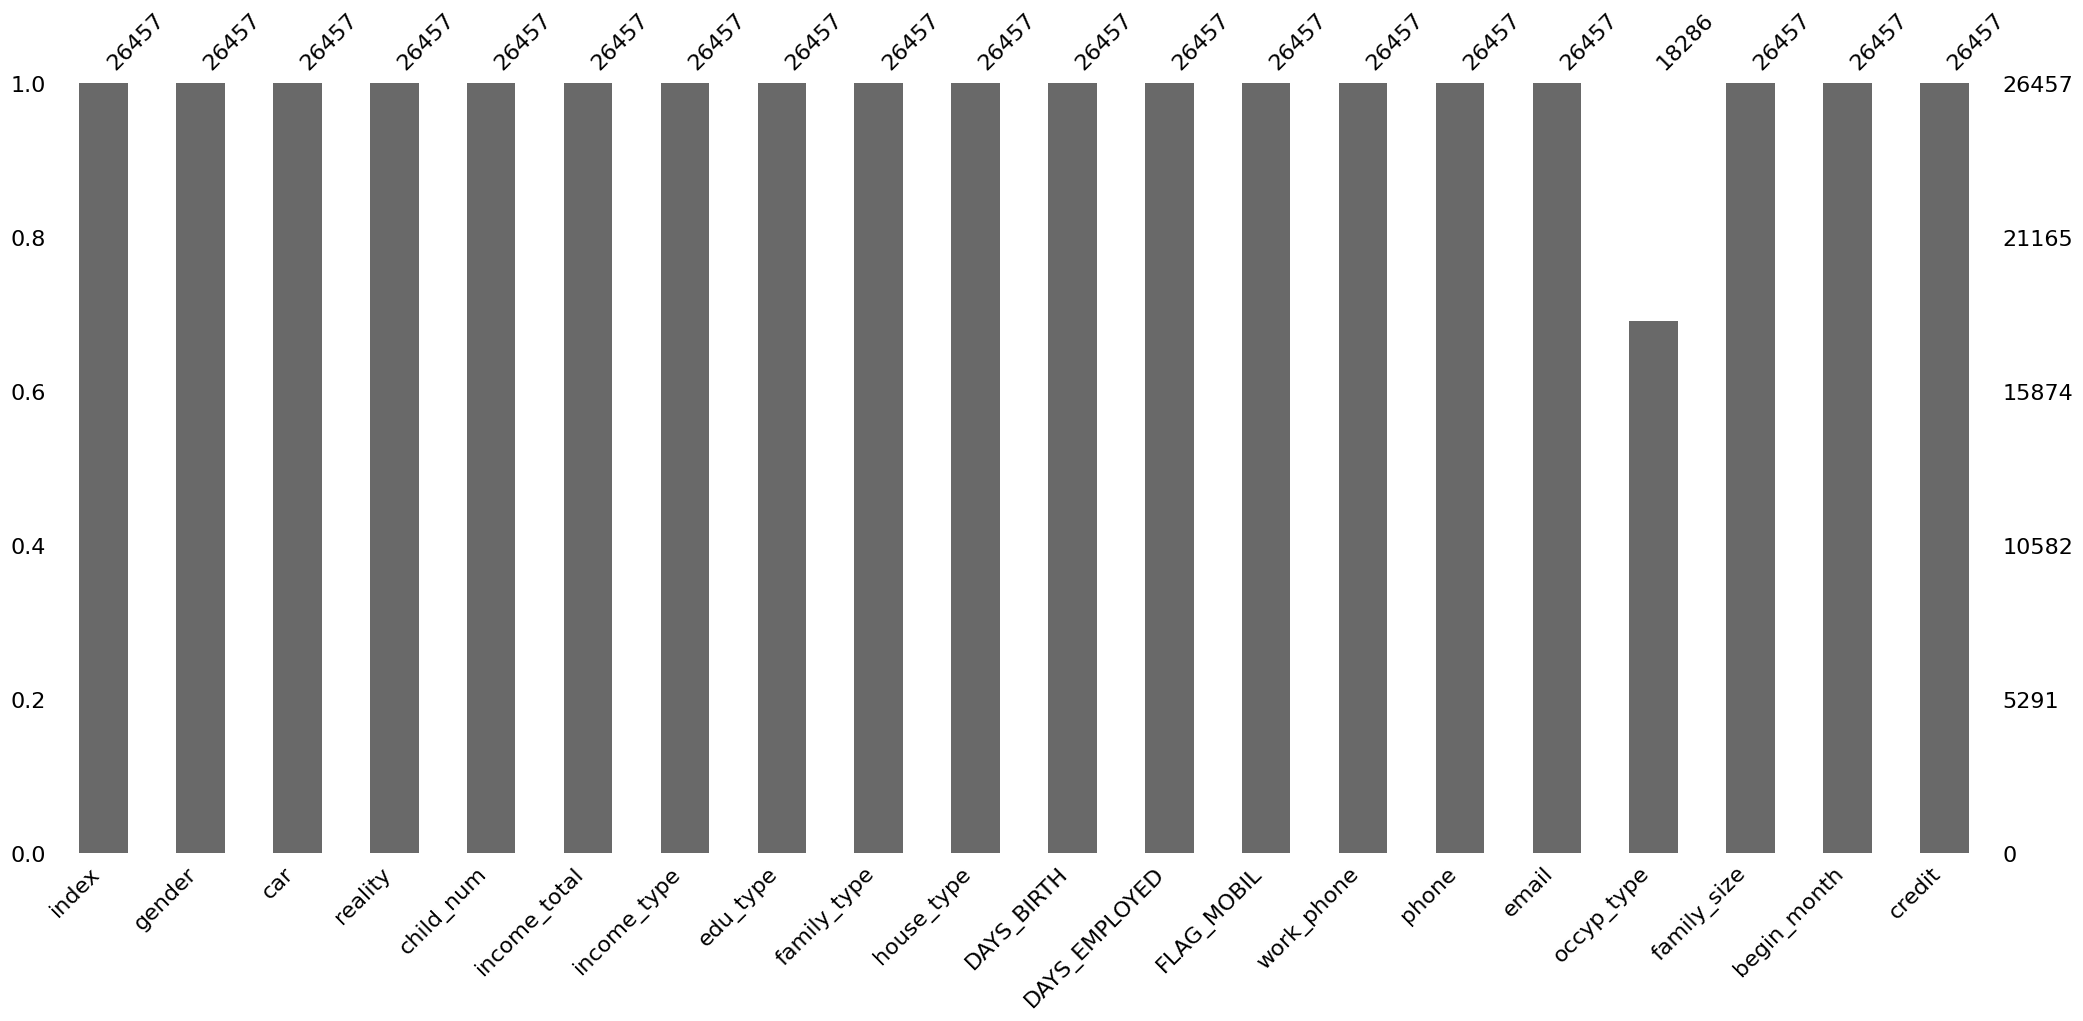

In [18]:
import missingno as msno 

msno.bar(train) 

#### 파생변수 생성

In [ ]:
train['age'] = (-train['DAYS_BIRTH'] // 365)

In [ ]:
train['length_of_employment'] = (-train['DAYS_EMPLOYED'] / 365).round(1)

## EDA

### 컬럼별 분포도

In [ ]:
column_list_Category = ["gender","car","reality","income_type","edu_type","family_type","house_type",
                        "work_phone","phone","email","occyp_type","family_size"]
column_list_continuous = ["child_num","income_total","DAYS_BIRTH","DAYS_EMPLOYED","begin_month"]
column_label = "credit"

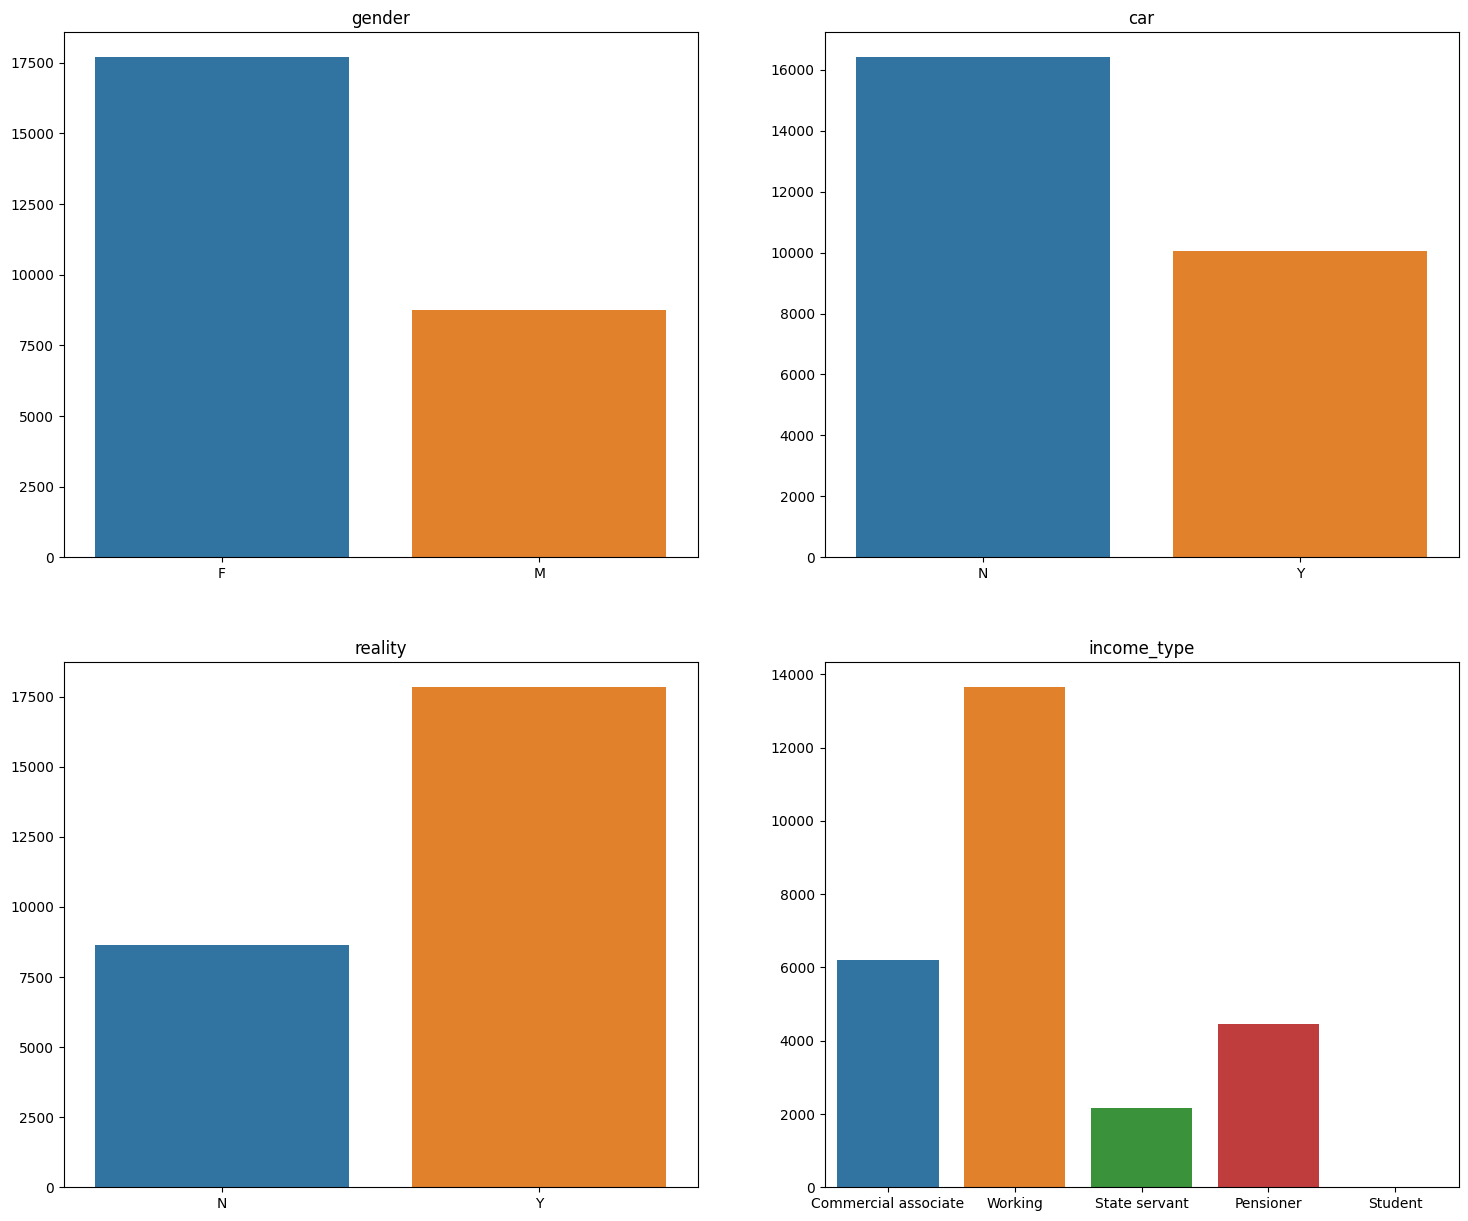

In [ ]:
plt.figure(figsize=(18,15))

for num in range(0, 4):
    plt.subplot(2,2, (num+1) )
    sns.countplot(x=train[column_list_Category[num]], data = train);
    plt.xlabel("")
    plt.ylabel("")
    plt.title(column_list_Category[num])

In [ ]:
# income_type에 따른 credit 분포

pd.crosstab(train['income_type'], train['credit'], margins='total', margins_name='Total')

credit,0.0,1.0,2.0,Total
income_type,,,,
Commercial associate,782,1344,4076,6202
Pensioner,536,1084,2829,4449
State servant,265,489,1400,2154
Student,0,3,4,7
Working,1639,3347,8659,13645
Total,3222,6267,16968,26457


- Student 데이터가 매우 적다.

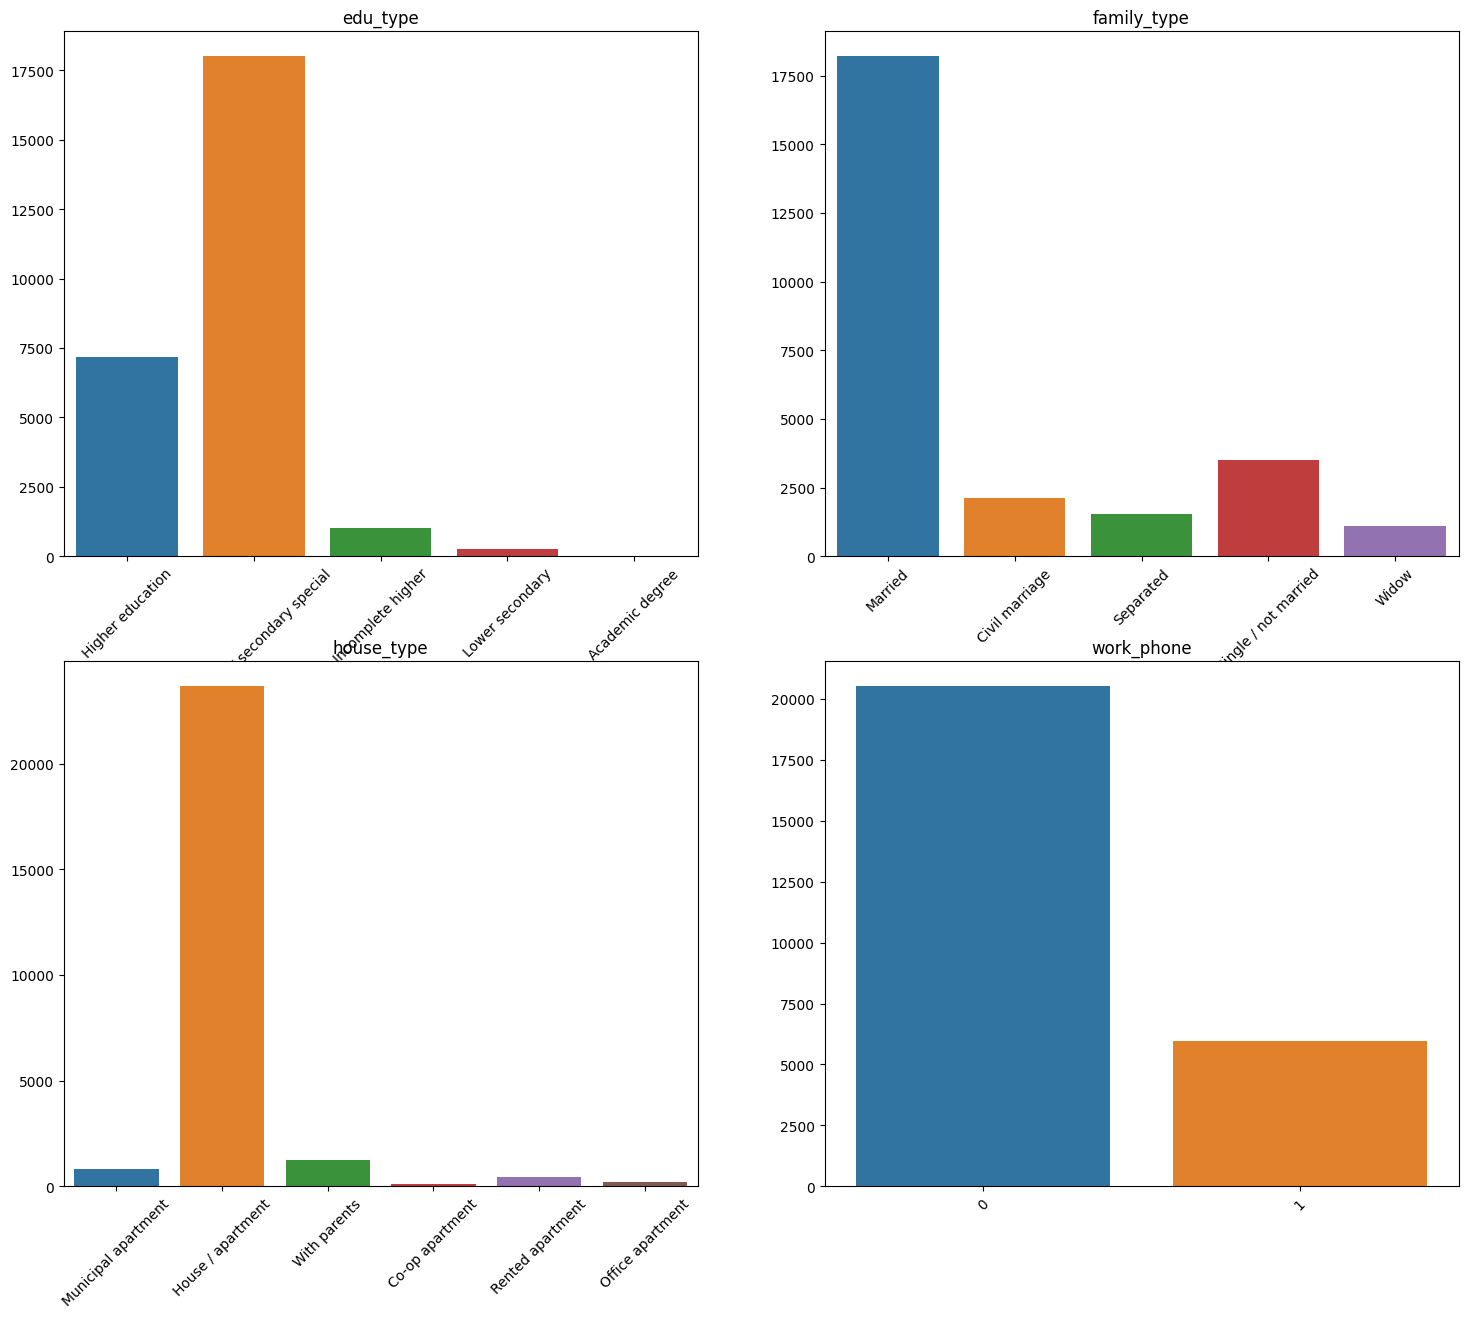

In [ ]:
plt.figure(figsize=(18,15))

for num in range(4, 8):
    plt.subplot(2,2, (num-3) )
    sns.countplot(x=train[column_list_Category[num]], data = train);
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.ylabel("")
    plt.title(column_list_Category[num])

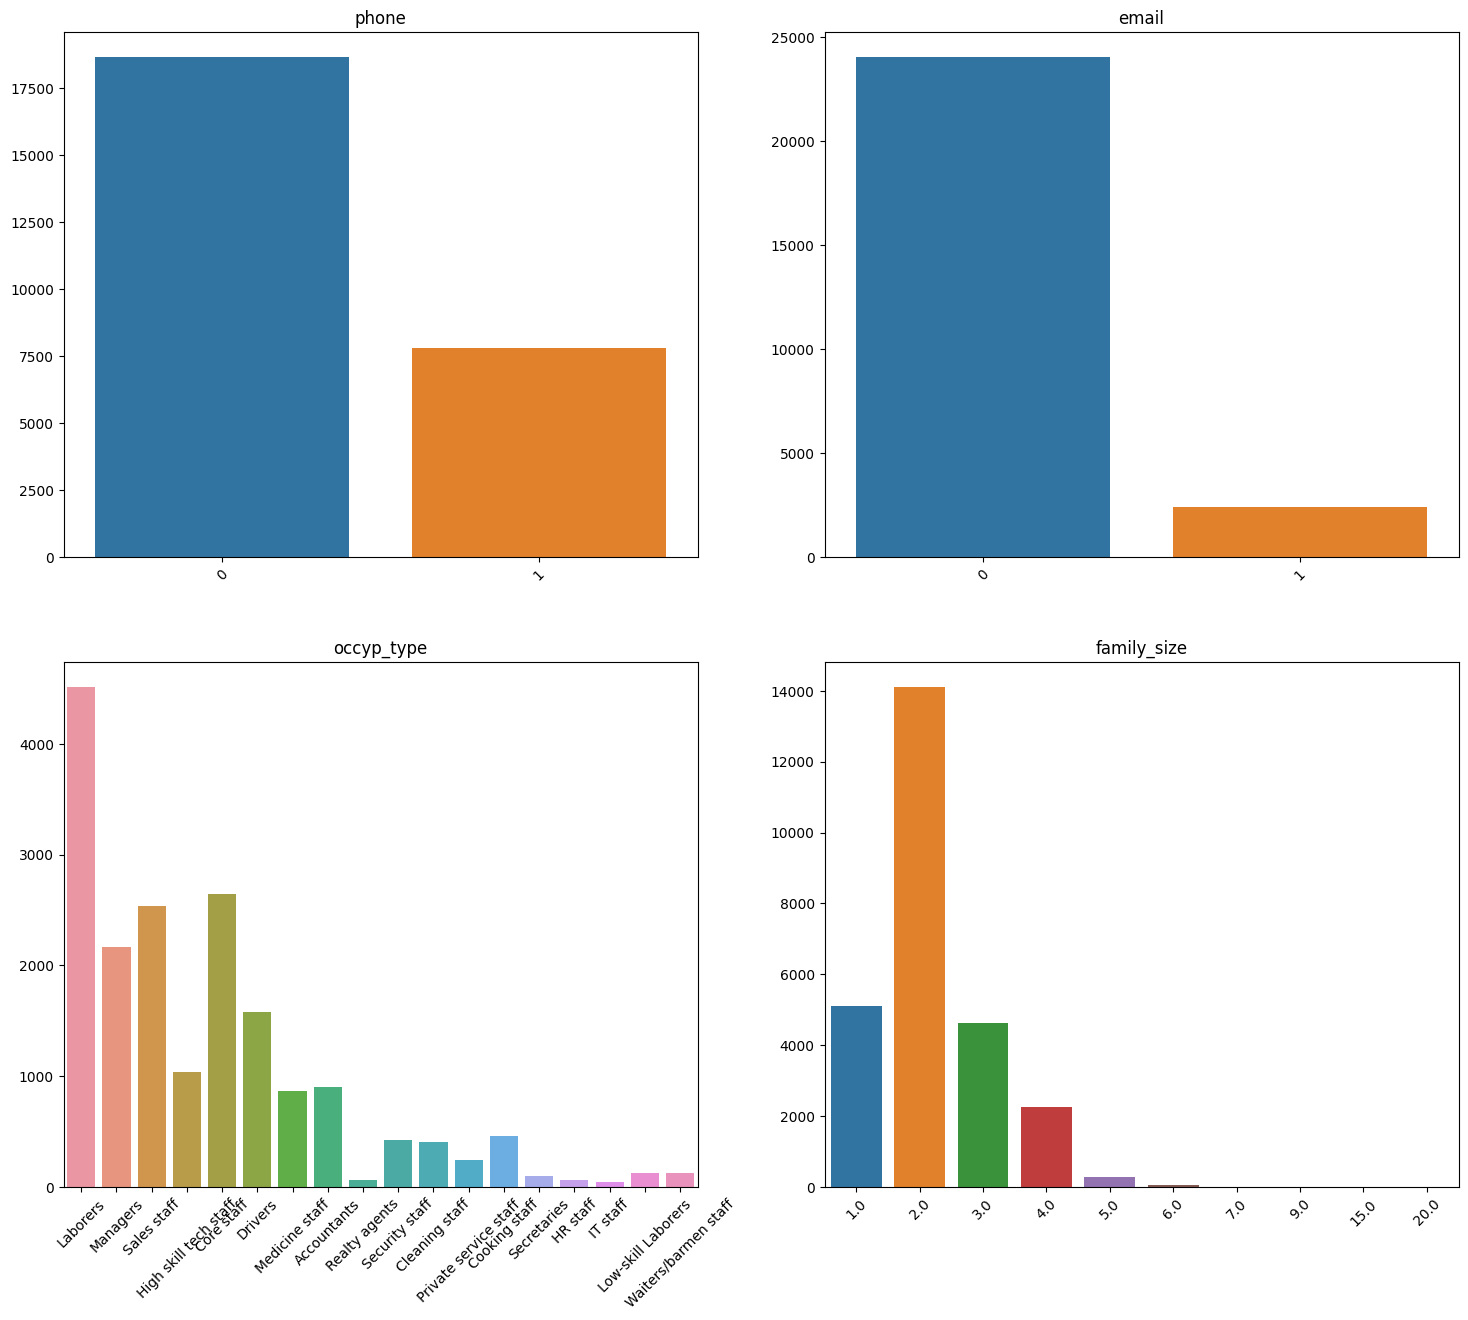

In [ ]:
plt.figure(figsize=(18,15))

for num in range(8, 12):
    plt.subplot(2,2, (num-7) )
    sns.countplot(x=train[column_list_Category[num]], data = train);
    plt.xlabel("")
    plt.xticks(rotation=45)
    plt.ylabel("")
    plt.title(column_list_Category[num])

<Axes: xlabel='FLAG_MOBIL', ylabel='count'>

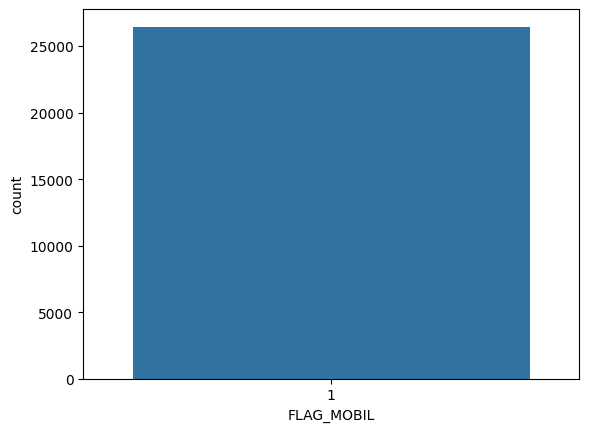

In [ ]:
sns.countplot(x='FLAG_MOBIL', data=train)

- FLAG_MOBIL 컬럼에는 1인 값 밖에 없다.

In [ ]:
# 가족 인원수에 따른 credit 분포
pd.crosstab(train['family_size'], train['credit'], margins='total', margins_name='Total')

credit,0.0,1.0,2.0,Total
family_size,,,,
1.0,605,1318,3186,5109
2.0,1720,3249,9137,14106
3.0,610,1088,2934,4632
4.0,251,520,1489,2260
5.0,27,74,190,291
6.0,7,12,25,44
7.0,2,6,1,9
9.0,0,0,2,2
15.0,0,0,3,3


#### family_size컬럼과 child_num컬럼과의 관계

- family_size(가족 수)가 6일때, child_num(자녀 수)는 4,5
- family_size(가족 수)가 7일때, child_num(자녀 수)는 5
- family_size(가족 수)가 9일때, child_num(자녀 수)는 7
- family_size(가족 수)가 15일때, child_num(자녀 수)는 14
- family_size(가족 수)가 20일때, child_num(자녀 수)는 19

In [ ]:
family_size_6 = train[train['family_size'] == 6]
child_num_values = family_size_6['child_num'].unique()
print(child_num_values)

[4 5]


In [ ]:
family_size_7 = train[train['family_size'] == 7]
child_num_values = family_size_7['child_num'].unique()
print(child_num_values)

[5]


In [ ]:
family_size_9 = train[train['family_size'] == 9]
child_num_values = family_size_9['child_num'].unique()
print(child_num_values)

[7]


In [ ]:
family_size_15 = train[train['family_size'] == 15]
child_num_values = family_size_15['child_num'].unique()
print(child_num_values)

[14]


In [ ]:
family_size_20 = train[train['family_size'] == 20]
child_num_values = family_size_20['child_num'].unique()
print(child_num_values)

[19]


#### 소득분포 확인

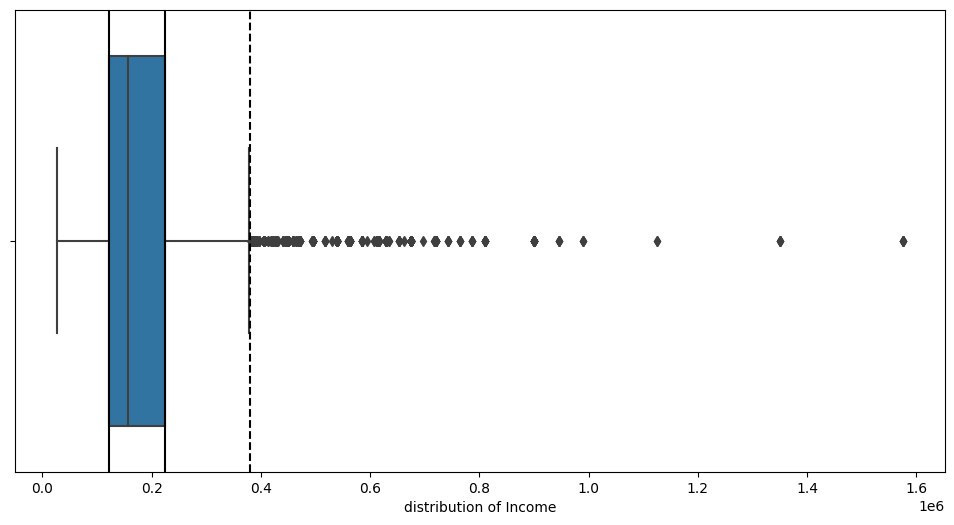

In [ ]:
income = train['income_total']
q1 = np.percentile(income, 25)
q3 = np.percentile(income, 75)

iqr = q3 - q1

upper_fence = q3 + iqr * 1.5

plt.figure(figsize=(12,6))
sns.boxplot(data=train, x='income_total')
plt.xlabel('distribution of Income')
plt.axvline(x=q1, color='black')
plt.axvline(x=q3, color='black')
plt.axvline(x=upper_fence, color='black', ls='dashed')
plt.show()

In [ ]:
columns = ['income_total','age','length_of_employment','family_size','begin_month']

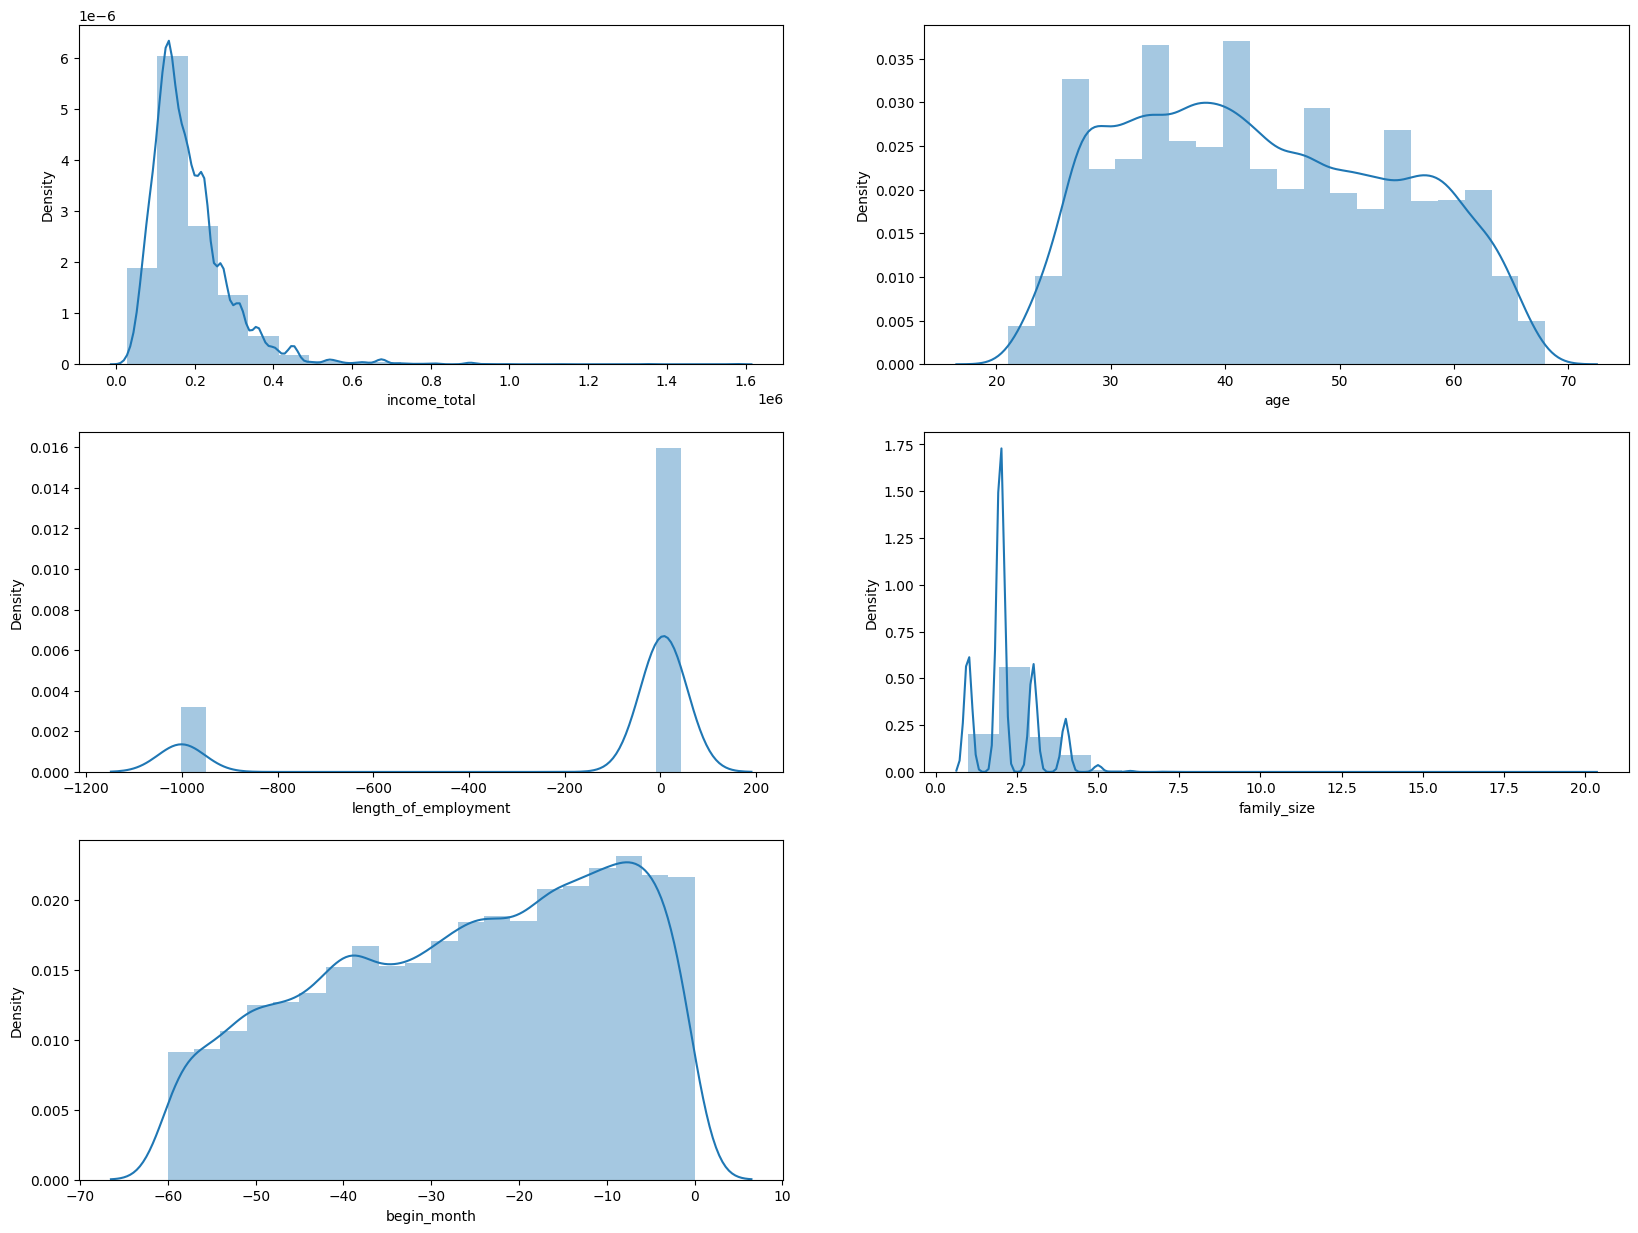

In [ ]:
plt.figure(figsize = (20,15))
for i in range(5):
    plt.subplot(3,2,i+1)
    sns.distplot(train[columns[i]],bins=20)
plt.show()

In [ ]:
train['begin_month'] = train['begin_month'].apply(lambda x :-x)

In [ ]:
# log 변환할 columns 지정
columns = ['income_total','age','length_of_employment','family_size','begin_month']

# log 변환 함수 정의
def log_transformation(x):
    return np.log(x+1)

# columns에 있는 모든 컬럼에 log 변환 적용
for col in columns:
    train[col] = log_transformation(train[col])

#### 로그 변환한 후 데이터 분포 확인

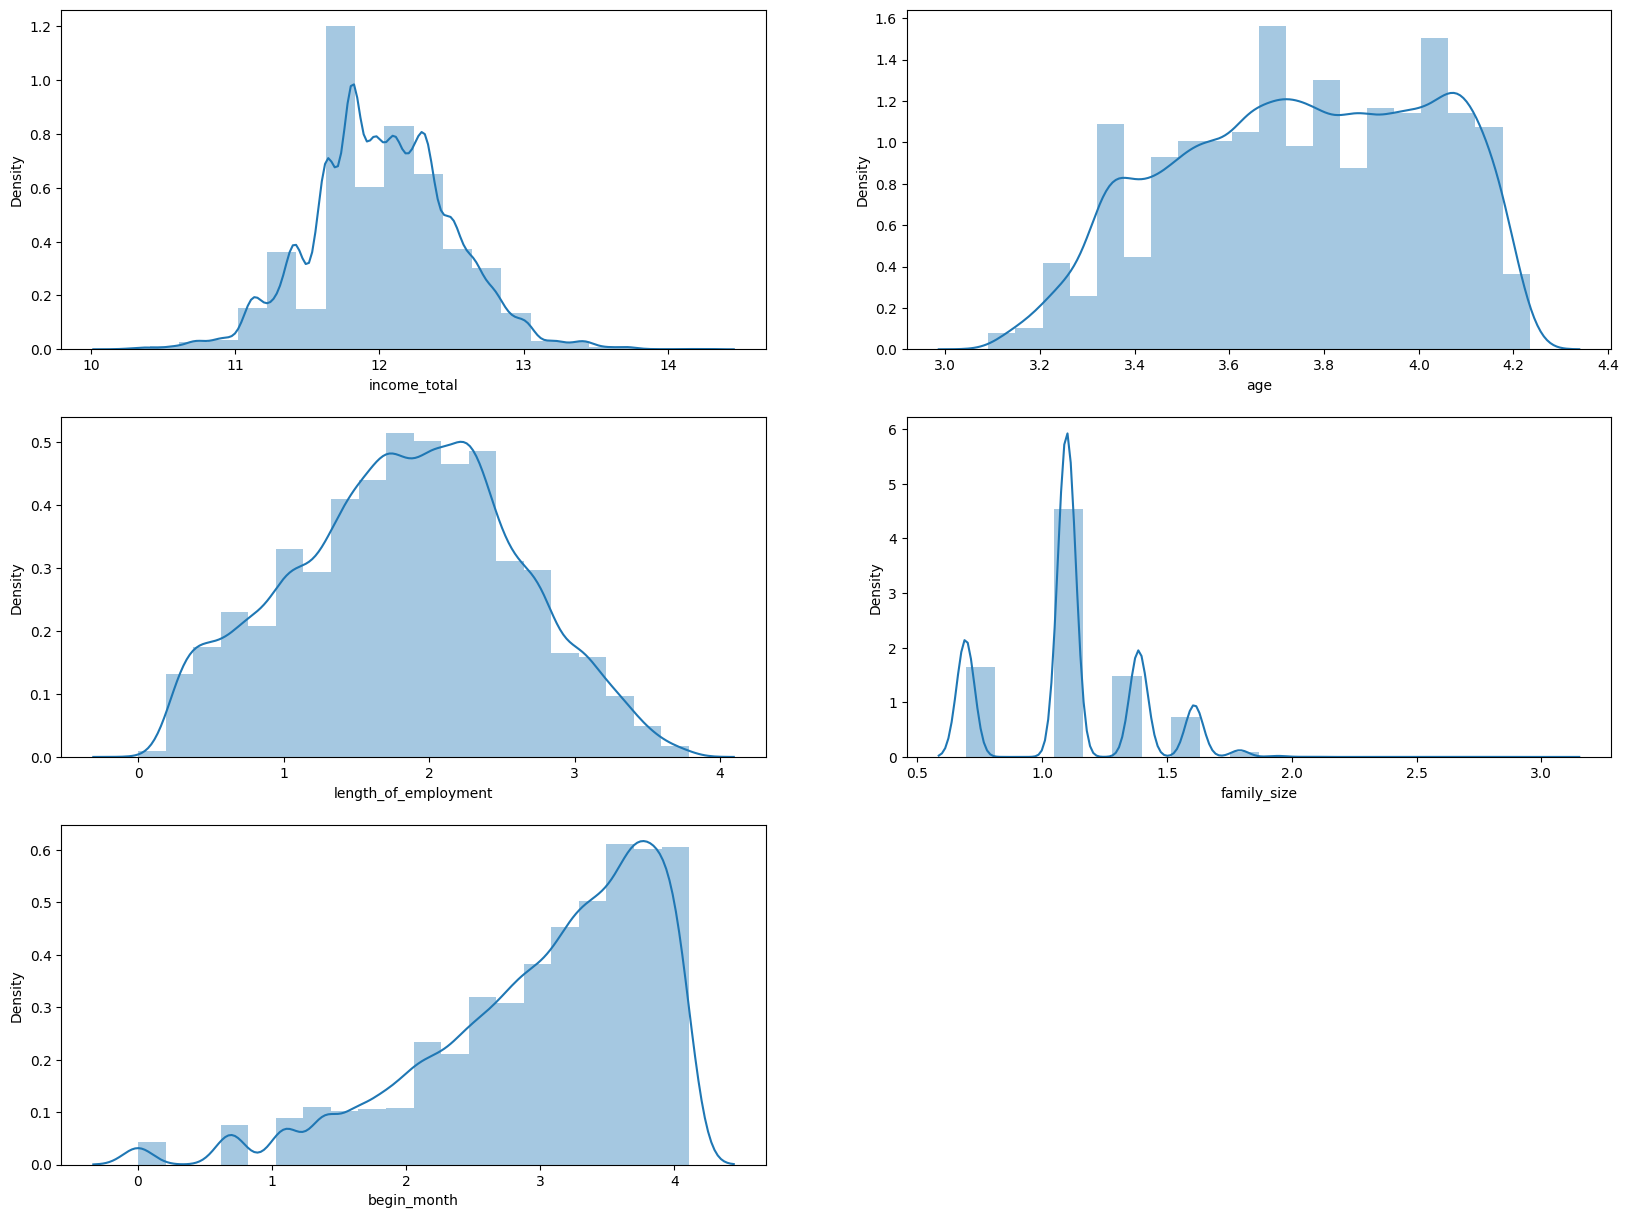

In [ ]:
plt.figure(figsize = (20,15))
for i in range(5):
    plt.subplot(3,2,i+1)
    sns.distplot(train[columns[i]],bins=20)
plt.show()

#### credit 컬럼의 데이터 분포 시각화

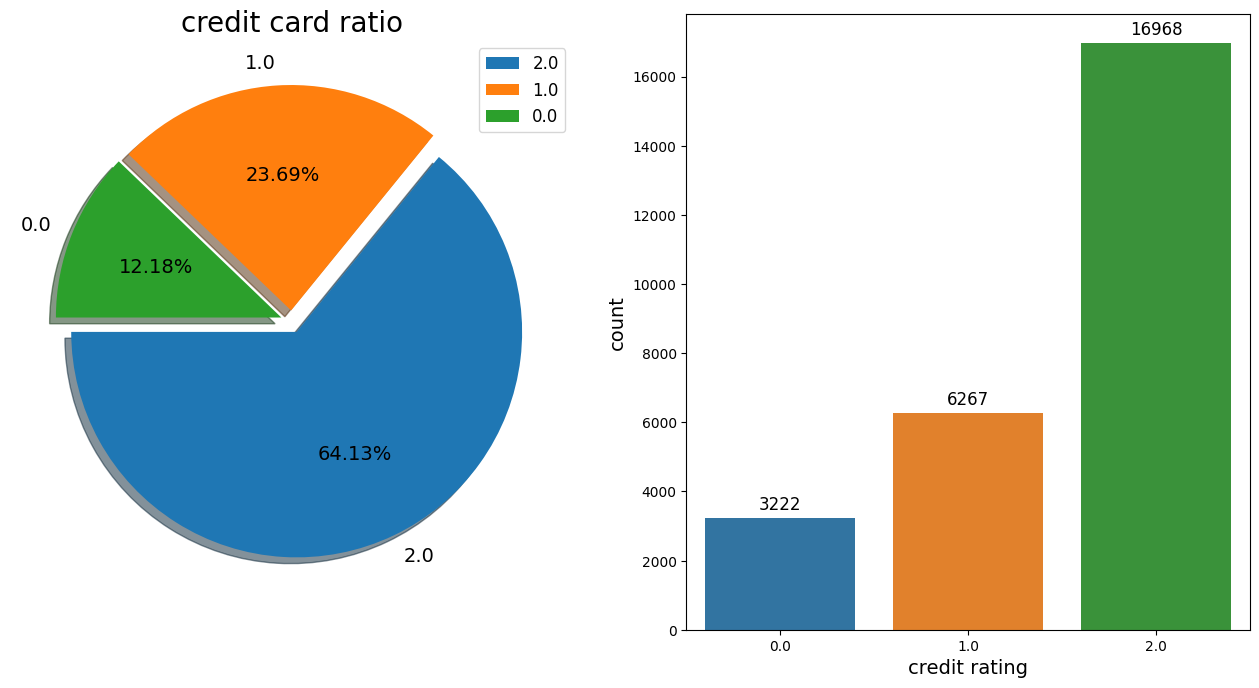

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # 1행 2열의 subplot 생성, 크기는 16x8

# 첫 번째 subplot에 파이 차트 그리기
# credit 열의 값들을 count하여 파이 차트로 그리기
# credit 값이 0, 1, 2일 때 각각 green, orange, blue 색상으로 설정
ax[0].pie(train['credit'].value_counts(), labels=train['credit'].value_counts().index,
          autopct="%.2f%%", shadow=True, startangle=180, textprops={'fontsize': 14},explode=[0.05, 0.05, 0.05])
ax[0].set_title('credit card ratio', size=20)  # 첫 번째 subplot 제목 설정

# train 데이터프레임의 'credit' 열을 x축으로 하는 카운트 플롯을 두 번째 subplot에 그리기
sns.countplot(x=train['credit'], ax=ax[1])

# 그래프에 count 수를 표기하기 위해 아래 코드 추가
# ax[1]의 모든 막대에 대해 반복문 실행
# 각 막대의 높이에 해당하는 count 수를 막대 위에 표시
for p in ax[1].patches:
    # 막대의 높이를 가져와서 포맷팅하여 문자열로 변환하고, 막대의 중앙에 위치하도록 좌표 설정
    # 텍스트 크기를 더 크게 설정
    ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 10), textcoords='offset points',
                   fontsize=12)
    
# 첫 번째 subplot에 label 추가
ax[0].legend(labels=train['credit'].value_counts().index, loc='upper right', fontsize=12)

# 두 번째 subplot에 label 추가
ax[1].set_xlabel('credit rating', size=14)
ax[1].set_ylabel('count', size=14)

# 그래프 출력하기
plt.show()

- credit 값이 낮을수록 더 좋은 신용등급이다.

#### 상관계수 확인

<Axes: >

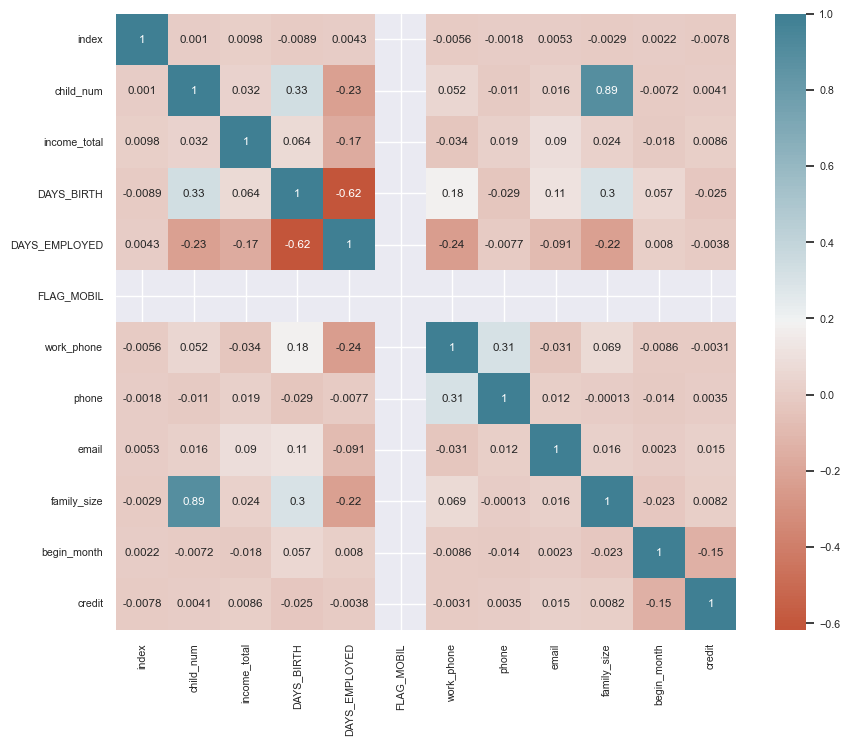

In [20]:
corr_matrix = train.corr()

# 히트맵 그리기
sns.set(font_scale=0.7) # annot의 fontsize를 줄이기 위해 폰트 크기 조정
plt.figure(figsize=(10, 8)) # 그림의 크기를 키우기 위해 figsize 조정
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

### 이상치값 확인

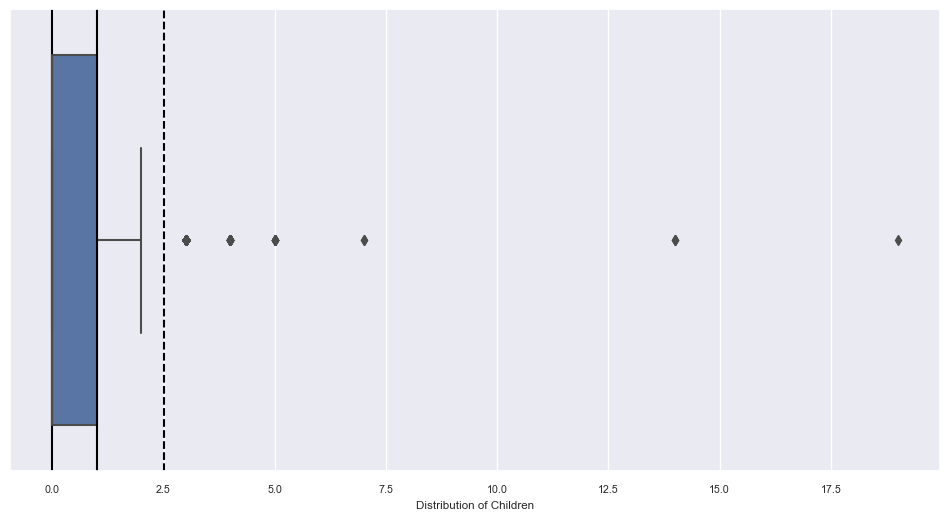

In [ ]:
# 자녀 수 확인, 2.5명보다 큰 값은 이상치
child = train['child_num']
q1 = np.percentile(child, 25)
q3 = np.percentile(child, 75)

iqr = q3 - q1

upper_fence = q3 + iqr * 1.5

plt.figure(figsize=(12,6))
sns.boxplot(data=train, x='child_num')
plt.xlabel('Distribution of Children')
plt.axvline(x=q1, color='black')
plt.axvline(x=q3, color='black')
plt.axvline(x=upper_fence, color='black', ls='dashed')
plt.show()

### 중복 데이터값

- index 컬럼 제외 중복 데이터 3155개

In [ ]:
train.drop(["index"], axis = 1).duplicated(keep = False).sum()

3155

- index와 begin_month 컬럼을 제외한 중복 데이터 20375개

In [ ]:
train.drop(["index","begin_month"], axis = 1).duplicated(keep = False).sum()

20375

- index, begin_month, credit 컬럼을 제외한 중복 데이터 23208개

In [ ]:
train.drop(["index","begin_month","credit"], axis = 1).duplicated(keep = False).sum()

23208

# ML Modeling

- 함수 정의

In [6]:
# income_type label encoding, 명목형 변수들을 Label Encoder로 변환
from sklearn.preprocessing import LabelEncoder

def MakeLabel(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [8]:
# 평가 지표 얻는 함수

def get_result(x_train, y_train, x_test, y_test, cat_feature):
    dt_clf = DecisionTreeClassifier()
    rf_clf = RandomForestClassifier()
    xg = XGBClassifier()
    lgbm = LGBMClassifier()    
    
    # DecisionTree
    clf = dt_clf
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(x_test)
    clf_proba = clf.predict_proba(x_test)
    print('=' * 10 + 'Model Name : DecisonTree')
    print('Confusion Matrix : ', confusion_matrix(y_test, clf_pred))
    print('Classification Report: ', classification_report(y_test, clf_pred))
    print('LogLoss : ', log_loss(y_test, clf_proba))
    
    # xgbcBoost
    xg = XGBClassifier()
    params = {
        "n_estimators" : [1000, 2000],
        "max_depth" : [5, 9],
        "random_state" : [13]
    }
    clf = GridSearchCV(xg, param_grid=params, cv=2, scoring="neg_log_loss")
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(x_test)
    clf_proba = clf.predict_proba(x_test)
    print('=' * 10 + 'Model Name : XGBCboost' + '=' * 10)
    print('Confusion Matrix : ', confusion_matrix(y_test, clf_pred))
    print('Classification Report: ', classification_report(y_test, clf_pred))
    print('LogLoss : ', log_loss(y_test, clf_proba))
    
    
    # RandomFroest
    params = {
    "n_estimators" : [1000, 1500, 2000],
    "random_state" : [13]}
    clf = GridSearchCV(rf_clf, param_grid=params, cv = 5, scoring="neg_log_loss")
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(x_test)
    clf_proba = clf.predict_proba(x_test)
    print('=' * 10 + 'Model Name : RandomForest' + '=' * 10)
    print('Confusion Matrix : ', confusion_matrix(y_test, clf_pred))
    print('Classification Report: ', classification_report(y_test, clf_pred))
    print('LogLoss : ', log_loss(y_test, clf_proba))
    
    #lgbm
    params = {
    "n_estimators" : [1000, 1500, 2000],
    "random_state" : [13]
    }
    clf = GridSearchCV(lgbm, param_grid=params, cv=2, scoring="neg_log_loss")
    clf.fit(x_train, y_train)

    clf_pred = clf.predict(x_test)
    clf_proba = clf.predict_proba(x_test)
    print('=' * 10 + 'Model Name : LightGBM' + '=' * 10)
    print('Confusion Matrix : ', confusion_matrix(y_test, clf_pred))
    print('Classification Report: ', classification_report(y_test, clf_pred))
    print('LogLoss : ', log_loss(y_test, clf_proba))

    #catBoost
    cat = CatBoostClassifier(n_estimators=3000, max_depth=10, random_seed=1000, learning_rate=0.04, bootstrap_type ='Bernoulli')
    cat.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=50,
    verbose=100, cat_features = cat_feature)
    cat_pred = cat.predict(x_test)
    cat_proba = cat.predict_proba(x_test)
    
    print('=' * 10 + 'Model Name : CatBoost' + '=' * 10)
    print('Confusion Matrix : ', confusion_matrix(y_test, cat_pred))
    print('Classification Report: ', classification_report(y_test, cat_pred))
    print('LogLoss : ', log_loss(y_test, cat_proba))

In [9]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [10]:
# 상관없는 컬럼 제거
train.drop(['index', 'FLAG_MOBIL', 'family_size'], axis=1, inplace=True)

# 이상치 제거
index = train.loc[train['child_num'] >= 5].index
train.drop(index, axis=0, inplace=True)

In [11]:
# NaN 값 제거
train = train.dropna()
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,credit
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,-26.0,2.0
5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,0,0,1,High skill tech staff,-18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,F,N,Y,0,202500.0,Working,Higher education,Married,House / apartment,-12831,-803,1,1,0,Accountants,-44.0,1.0
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,Core staff,-2.0,1.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,Core staff,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,0,0,0,Laborers,-59.0,2.0


In [12]:
# 범주형 변수 encoding
encoding_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

for column in encoding_columns:
    MakeLabel(train, column)

# 365243 0변환, 음수값 양수변환
index= train.loc[train['DAYS_EMPLOYED'] > 0].index
train.loc[index, 'DAYS_EMPLOYED'] = 0
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['begin_month'] = -train['begin_month']

# 연속형 변수 단위 변환
train["income_total"] = train["income_total"] / 10000
train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
train["credit"] = train["credit"].astype('int')

train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,begin_month,credit
1,0,0,1,1,24.75,0,4,0,1,31.178082,128.333333,0,0,1,8,5.0,1
2,1,1,1,0,45.00,4,1,1,1,52.293151,369.500000,0,1,0,10,22.0,2
3,0,0,1,0,20.25,0,4,1,1,41.336986,174.333333,0,1,0,14,37.0,0
4,0,1,1,0,15.75,2,1,1,1,41.197260,175.416667,0,0,0,10,26.0,2
5,0,0,1,2,27.00,4,4,1,1,36.747945,416.333333,0,0,1,6,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26451,0,0,1,0,20.25,4,1,1,1,35.153425,66.916667,1,1,0,0,44.0,1
26452,0,0,0,2,22.50,2,4,1,1,33.093151,165.333333,0,0,0,3,2.0,1
26454,0,1,0,0,29.25,4,4,0,5,27.621918,167.916667,0,0,0,3,25.0,2
26455,1,0,1,0,17.10,4,2,3,1,27.794521,8.916667,0,0,0,8,59.0,2


In [14]:
# 첫번째 표 결과값(기본모델)
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cat_feature = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

get_result(X_train, y_train, X_test, y_test, cat_feature)

==========Model Name : DecisonTree
Confusion Matrix :  [[ 150   88  186]
 [ 104  419  330]
 [ 275  371 1732]]
Classification Report:                precision    recall  f1-score   support

           0       0.28      0.35      0.31       424
           1       0.48      0.49      0.48       853
           2       0.77      0.73      0.75      2378

    accuracy                           0.63      3655
   macro avg       0.51      0.52      0.52      3655
weighted avg       0.65      0.63      0.64      3655

LogLoss :  12.72092811070712
==========Model Name : XGBCboost==========
Confusion Matrix :  [[ 114   64  246]
 [  48  409  396]
 [ 100  198 2080]]
Classification Report:                precision    recall  f1-score   support

           0       0.44      0.27      0.33       424
           1       0.61      0.48      0.54       853
           2       0.76      0.87      0.82      2378

    accuracy                           0.71      3655
   macro avg       0.60      0.54      0.5

## 파생변수 생성

In [15]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [16]:
# 상관없는 컬럼 제거
train.drop(['index', 'FLAG_MOBIL', 'family_size'], axis=1, inplace=True)

# 이상치 제거
index = train.loc[train['child_num'] >= 5].index
train.drop(index, axis=0, inplace=True)

# 365243 0변환, 음수값 양수변환
index= train.loc[train['DAYS_EMPLOYED'] > 0].index
train.loc[index, 'DAYS_EMPLOYED'] = 0
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['begin_month'] = -train['begin_month']

# 연속형 변수 단위 변환
train["income_total"] = train["income_total"] / 10000
train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
train["credit"] = train["credit"].astype('int')

# 범주형 데이터 분석을 통한 새로운 컬럼 생성
train.fillna("etc", inplace=True)
train["income_occupy"] = train["income_type"] + "_" + train["occyp_type"]
train["car_reality"] = train["car"].astype("str") + "_" + train["reality"].astype("str")

# 연속형 데이터 분석을 통한 새로운 컬럼 생성
train["card_begin_before_employed"] = (train["DAYS_EMPLOYED"] // 30) - train["begin_month"]

# 고용되기 전까지의 일수 계산
train['before_EMPLOYED'] = train['DAYS_BIRTH'] - \
    train['DAYS_EMPLOYED']

# 소득과 고용되기 전까지의 일수 비율 계산
train['income_total_befofeEMP_ratio'] = train['income_total'] / \
    train['before_EMPLOYED']

# 고용되기 전까지의 일수를 월 단위와 주 단위로 변환
train['before_EMPLOYED_m'] = np.floor(train['before_EMPLOYED'] / 30) - (
    (np.floor(train['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
train['before_EMPLOYED_w'] = np.floor(train['before_EMPLOYED'] / 7) - (
    (np.floor(train['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

# 나이, 태어난 월, 태어난 주(출생연도의 n주차) 계산
train['Age'] = train['DAYS_BIRTH'] // 365
train['DAYS_BIRTH_m'] = np.floor(train['DAYS_BIRTH'] / 30) - (
    (np.floor(train['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
train['DAYS_BIRTH_w'] = np.floor(train['DAYS_BIRTH'] / 7) - (
    (np.floor(train['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

# 근속연수, 고용된 달, 고용된 주(고용연도의 n주차) 계산
train['EMPLOYED'] = train['DAYS_EMPLOYED'] // 365
train['DAYS_EMPLOYED_m'] = np.floor(train['DAYS_EMPLOYED'] / 30) - (
    (np.floor(train['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
train['DAYS_EMPLOYED_w'] = np.floor(train['DAYS_EMPLOYED'] / 7) - (
    (np.floor(train['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

# 능력치 계산: 소득/(살아온 일수+ 근무일수)
train['ability'] = train['income_total'] / \
    (train['DAYS_BIRTH'] + train['DAYS_EMPLOYED'])

# 가족 수를 고려한 평균 소득 계산
train['income_mean'] = train['income_total'] / \
    (train['child_num'] + 1)

# 불필요한 데이터 컬럼 삭제
train.drop(["work_phone", "phone", "email", "income_type", "occyp_type"], axis=1, inplace=True)
train.drop(["gender", "car", "reality", "child_num"], axis=1, inplace=True)

encoding_columns = ['edu_type', 'family_type', 'house_type', 'car_reality', 'income_occupy']

for column in encoding_columns:
    MakeLabel(train, column)

train

,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,credit,income_occupy,car_reality,...,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean
0,20.25,1,1,2,38.079452,392.416667,6.0,1,18,0,...,0.0,-3.0,0.0,1.0,1.0,1.0,1.0,0.0,0.047039,20.250
1,24.75,4,0,1,31.178082,128.333333,5.0,1,8,1,...,-4.0,-2.0,0.0,1.0,0.0,0.0,4.0,2.0,0.155161,12.375
2,45.00,1,1,1,52.293151,369.500000,22.0,2,57,3,...,-11.0,-2.0,0.0,1.0,3.0,1.0,0.0,0.0,0.106687,45.000
3,20.25,4,1,1,41.336986,174.333333,37.0,0,14,1,...,-5.0,-3.0,0.0,1.0,1.0,0.0,5.0,0.0,0.093893,20.250
4,15.75,1,1,1,41.197260,175.416667,26.0,2,36,3,...,-5.0,0.0,0.0,1.0,1.0,0.0,5.0,1.0,0.072710,15.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,22.50,4,1,1,33.093151,165.333333,2.0,1,29,0,...,-5.0,-3.0,0.0,1.0,0.0,0.0,5.0,3.0,0.113392,7.500
26453,18.00,1,2,1,41.893151,206.250000,47.0,2,65,1,...,-6.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,0.072539,9.000
26454,29.25,4,0,5,27.621918,167.916667,25.0,2,50,2,...,-5.0,-1.0,0.0,0.0,3.0,0.0,5.0,3.0,0.149587,29.250
26455,17.10,2,3,1,27.794521,8.916667,59.0,2,55,1,...,0.0,2.0,0.0,0.0,3.0,0.0,0.0,1.0,0.465798,17.100


In [17]:
# 두번째 표 결과값
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cat_feature = ['edu_type', 'family_type', 'house_type', 'car_reality', 'income_occupy']

get_result(X_train, y_train, X_test, y_test, cat_feature)

==========Model Name : DecisonTree
Confusion Matrix :  [[ 183  146  327]
 [ 158  614  505]
 [ 344  545 2467]]
Classification Report:                precision    recall  f1-score   support

           0       0.27      0.28      0.27       656
           1       0.47      0.48      0.48      1277
           2       0.75      0.74      0.74      3356

    accuracy                           0.62      5289
   macro avg       0.50      0.50      0.50      5289
weighted avg       0.62      0.62      0.62      5289

LogLoss :  13.344408108009073
==========Model Name : XGBCboost==========
Confusion Matrix :  [[ 185  105  366]
 [  75  600  602]
 [ 146  286 2924]]
Classification Report:                precision    recall  f1-score   support

           0       0.46      0.28      0.35       656
           1       0.61      0.47      0.53      1277
           2       0.75      0.87      0.81      3356

    accuracy                           0.70      5289
   macro avg       0.60      0.54      0.

In [18]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [19]:
# 상관없는 컬럼 제거
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

# 이상치 제거
index = train.loc[train['child_num'] >= 5].index
train.drop(index, axis=0, inplace=True)
index = train[train["income_type"] == "Student"].index
train.drop(index, axis=0, inplace=True)

# 365243 0변환, 음수값 양수변환
index= train.loc[train['DAYS_EMPLOYED'] > 0].index
train.loc[index, 'DAYS_EMPLOYED'] = 0
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['begin_month'] = -train['begin_month']

# 개인의 식별번호 컬럼
train["SSN"] = train["gender"].astype("str") +  train["car"].astype("str") + train["child_num"].astype("str") +\
train["income_total"].astype("str") + train["income_type"].astype("str") + train["edu_type"].astype("str") + \
train["family_type"].astype("str") + train["house_type"].astype("str") + train["DAYS_BIRTH"].astype("str") + \
train["DAYS_EMPLOYED"].astype("str") + train["work_phone"].astype("str") + train["phone"].astype("str") + \
train["email"].astype("str") + train["occyp_type"].astype("str") + train["family_size"].astype("str")

# income_type과 occupy_type를 합친 수입과 직업의 새로운 컬럼과 자동차와 부동산 유무를 합친 새로운 컬럼 생성
train.fillna("etc", inplace=True)
train["income_occupy"] = train["income_type"] + "_" + train["occyp_type"]
train["car_reality"] = train["car"].astype("str") + "_" + train["reality"].astype("str")

# 분석에 유의미한 차이를 만들지 못하는 데이터 drop
train.drop(["work_phone", "phone", "email", "income_type", "occyp_type"], axis=1, inplace=True)
train.drop(["gender", "car", "reality", "child_num"], axis=1, inplace=True)

# 카드 발급 날짜를 기준으로 음수일 경우 직장이 없는 개월 수이며, 양수일 경우 카드 발급 받기 전부터 직장을 다님
train["card_begin_before_employed"] = (train["DAYS_EMPLOYED"] // 30) - train["begin_month"]

# 연속형 데이터의 단위를 조정
train["income_total"] = train["income_total"] / 10000
train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
train["credit"] = train["credit"].astype('int')

# 범주형 변수 encoding
encoding_columns = ['edu_type', 'family_type', 'house_type', 'income_occupy', 'car_reality','SSN']

for column in encoding_columns:
    MakeLabel(train, column)

train

,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,SSN,income_occupy,car_reality,card_begin_before_employed
0,20.25,1,1,2,38.079452,392.416667,2.0,6.0,1,1676,18,0,150.0
1,24.75,4,0,1,31.178082,128.333333,3.0,5.0,1,3740,8,1,46.0
2,45.00,1,1,1,52.293151,369.500000,2.0,22.0,2,7982,54,3,125.0
3,20.25,4,1,1,41.336986,174.333333,2.0,37.0,0,1690,14,1,32.0
4,15.75,1,1,1,41.197260,175.416667,2.0,26.0,2,4586,36,3,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,22.50,4,1,1,33.093151,165.333333,4.0,2.0,1,4147,29,0,64.0
26453,18.00,1,2,1,41.893151,206.250000,2.0,47.0,2,3599,62,1,35.0
26454,29.25,4,0,5,27.621918,167.916667,2.0,25.0,2,4987,47,2,42.0
26455,17.10,2,3,1,27.794521,8.916667,1.0,59.0,2,6022,52,1,-56.0


In [20]:
# 세번째 표 결과값
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cat_feature = ["house_type","edu_type","income_occupy","SSN"]

get_result(X_train, y_train, X_test, y_test, cat_feature)

==========Model Name : DecisonTree
Confusion Matrix :  [[ 199  143  284]
 [ 153  626  492]
 [ 333  624 2433]]
Classification Report:                precision    recall  f1-score   support

           0       0.29      0.32      0.30       626
           1       0.45      0.49      0.47      1271
           2       0.76      0.72      0.74      3390

    accuracy                           0.62      5287
   macro avg       0.50      0.51      0.50      5287
weighted avg       0.63      0.62      0.62      5287

LogLoss :  13.296870965920355
==========Model Name : XGBCboost==========
Confusion Matrix :  [[ 182   94  350]
 [  63  593  615]
 [ 117  279 2994]]
Classification Report:                precision    recall  f1-score   support

           0       0.50      0.29      0.37       626
           1       0.61      0.47      0.53      1271
           2       0.76      0.88      0.81      3390

    accuracy                           0.71      5287
   macro avg       0.62      0.55      0.

# 중복데이터 처리
## 중복데이터 삭제

In [21]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [22]:
# 상관없는 컬럼 제거
train.drop(['index', 'FLAG_MOBIL', 'family_size'], axis=1, inplace=True)

# 이상치 데이터 제거
drop_index = train[train["income_type"] == "Student"].index
train.drop(index=drop_index, axis=0, inplace=True)
drop_index =  train[train["child_num"] >= 5].index
train.drop(index=drop_index, axis=0, inplace=True)

# begin_month를 제외한 나머지 데이터의 중복이 있는 경우 데이터 삭제
df_index = train[train.drop(["begin_month"], axis=1).duplicated()].index
train = train.loc[df_index, :]

# 365243 0변환, 음수값 양수변환
index= train.loc[train['DAYS_EMPLOYED'] > 0].index
train.loc[index, 'DAYS_EMPLOYED'] = 0
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['begin_month'] = -train['begin_month']

# binary 데이터를 int형으로 변환
train["gender"] = train["gender"].apply(lambda x: 0 if x == "F" else 1)
train["car"] = train["car"].apply(lambda x: 0 if x == "N" else 1)
train["reality"] = train["reality"].apply(lambda x: 0 if x == "N" else 1)

# 범주형 데이터 분석을 통한 새로운 컬럼 생성
train.fillna("etc", inplace=True)
train["income_occupy"] = train["income_type"] + "_" + train["occyp_type"]
train["car_reality"] = train["car"].astype("str") + "_" + train["reality"].astype("str")

# 연속형 데이터 분석을 통한 새로운 컬럼 생성
train["card_begin_before_employed"] = (train["DAYS_EMPLOYED"] // 30) - train["begin_month"]

# 불필요한 데이터 컬럼 삭제
train.drop(["work_phone", "phone", "email", "income_type", "occyp_type"], axis=1, inplace=True)
train.drop(["gender", "car", "reality", "child_num"], axis=1, inplace=True)

# 연속형 데이터의 단위 조정
train["income_total"] = train["income_total"] / 10000
train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
train["credit"] = train["credit"].astype('int')

# 범주형 데이터에 대한 Label값 조정
make_label = LabelEncoder()

train["edu_type"] = make_label.fit_transform(train["edu_type"])
train["family_type"] = make_label.fit_transform(train["family_type"])
train["house_type"] = make_label.fit_transform(train["house_type"])
train["income_occupy"] = make_label.fit_transform(train["income_occupy"])
train["car_reality"] = make_label.fit_transform(train["car_reality"])

In [23]:
# 네번째 표 결과값
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cat_feature = ["house_type","edu_type","income_occupy", 'family_type']

get_result(X_train, y_train, X_test, y_test, cat_feature)

==========Model Name : DecisonTree
Confusion Matrix :  [[ 112   70  110]
 [  64  292  221]
 [ 134  302 1566]]
Classification Report:                precision    recall  f1-score   support

           0       0.36      0.38      0.37       292
           1       0.44      0.51      0.47       577
           2       0.83      0.78      0.80      2002

    accuracy                           0.69      2871
   macro avg       0.54      0.56      0.55      2871
weighted avg       0.70      0.69      0.69      2871

LogLoss :  11.091120205774637
==========Model Name : XGBCboost==========
Confusion Matrix :  [[ 103   47  142]
 [  23  308  246]
 [  62  151 1789]]
Classification Report:                precision    recall  f1-score   support

           0       0.55      0.35      0.43       292
           1       0.61      0.53      0.57       577
           2       0.82      0.89      0.86      2002

    accuracy                           0.77      2871
   macro avg       0.66      0.59      0.

## 중복데이터 처리 & Clustering / PCA

In [24]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [25]:
# 상관없는 컬럼 제거
train.drop(['index', 'FLAG_MOBIL', 'family_size'], axis=1, inplace=True)

# 이상치 데이터 제거
drop_index = train[train["income_type"] == "Student"].index
train.drop(index=drop_index, axis=0, inplace=True)
drop_index =  train[train["child_num"] >= 5].index
train.drop(index=drop_index, axis=0, inplace=True)

# begin_month를 제외한 나머지 데이터의 중복이 있는 경우 데이터 삭제
df_index = train[train.drop(["begin_month"], axis=1).duplicated()].index
train = train.loc[df_index, :]

# 365243 0변환, 음수값 양수변환
index= train.loc[train['DAYS_EMPLOYED'] > 0].index
train.loc[index, 'DAYS_EMPLOYED'] = 0
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']
train['DAYS_EMPLOYED'] = -train['DAYS_EMPLOYED']
train['begin_month'] = -train['begin_month']

# binary 데이터를 int형으로 변환
train["gender"] = train["gender"].apply(lambda x: 0 if x == "F" else 1)
train["car"] = train["car"].apply(lambda x: 0 if x == "N" else 1)
train["reality"] = train["reality"].apply(lambda x: 0 if x == "N" else 1)

# 범주형 데이터 분석을 통한 새로운 컬럼 생성
train.fillna("etc", inplace=True)
train["income_occupy"] = train["income_type"] + "_" + train["occyp_type"]
train["car_reality"] = train["car"].astype("str") + "_" + train["reality"].astype("str")

# 연속형 데이터 분석을 통한 새로운 컬럼 생성
train["card_begin_before_employed"] = (train["DAYS_EMPLOYED"] // 30) - train["begin_month"]

# 불필요한 데이터 컬럼 삭제
train.drop(["work_phone", "phone", "email", "income_type", "occyp_type"], axis=1, inplace=True)
train.drop(["gender", "car", "reality", "child_num"], axis=1, inplace=True)

# 연속형 데이터의 단위 조정
#train["income_total"] = train["income_total"] / 10000
#train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
#train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
#train["credit"] = train["credit"].astype('int')

# 범주형 데이터에 대한 Label값 조정
make_label = LabelEncoder()

train["edu_type"] = make_label.fit_transform(train["edu_type"])
train["family_type"] = make_label.fit_transform(train["family_type"])
train["house_type"] = make_label.fit_transform(train["house_type"])
train["income_occupy"] = make_label.fit_transform(train["income_occupy"])
train["car_reality"] = make_label.fit_transform(train["car_reality"])

In [26]:
from sklearn.decomposition import PCA

# credit 열을 제외한 모든 열을 features로 지정
features = train.drop('credit', axis=1)

# PCA 모델 생성, n_components를 15개로 설정
pca = PCA(n_components=5)

pca_list = [f'pca_{i}' for i in range(5)]

# PCA 모델을 features에 적용하여 새로운 열 추가
train[pca_list] = pca.fit_transform(features)

# 결과 확인
train.head()

,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,credit,income_occupy,car_reality,card_begin_before_employed,pca_0,pca_1,pca_2,pca_3,pca_4
319,225000.0,4,0,1,12640,399,21.0,2.0,0,0,-8.0,34363.988963,-3200.757185,-1987.425324,-6.224106,31.967499
330,270000.0,4,2,1,19363,12332,18.0,2.0,31,0,393.0,79369.323502,3440.032983,9978.194697,-22.554251,11.277802
419,135000.0,4,1,1,18820,3185,7.0,1.0,47,3,99.0,-55646.814477,2680.526736,1083.579480,-30.226735,-14.548443
421,180000.0,4,1,1,10351,1322,16.0,2.0,56,2,28.0,-10627.623844,-5630.205751,-1014.952441,-13.916460,-19.997199
457,112500.0,1,0,1,10551,3000,17.0,2.0,3,3,83.0,-78124.404891,-5646.375095,799.608453,-13.279224,36.343513


In [27]:
from sklearn.cluster import KMeans

# KMeans 모델 생성
kmeans = KMeans(n_clusters=30, random_state=42)

kmeans_train = train.drop(['credit'], axis=1)

# 모델 학습
kmeans.fit(kmeans_train)

# 클러스터링 결과를 데이터프레임에 추가
train['cluster'] = kmeans.labels_
train

,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,credit,income_occupy,car_reality,card_begin_before_employed,pca_0,pca_1,pca_2,pca_3,pca_4,cluster
319,225000.0,4,0,1,12640,399,21.0,2.0,0,0,-8.0,34363.988963,-3200.757185,-1987.425324,-6.224106,31.967499,11
330,270000.0,4,2,1,19363,12332,18.0,2.0,31,0,393.0,79369.323502,3440.032983,9978.194697,-22.554251,11.277802,14
419,135000.0,4,1,1,18820,3185,7.0,1.0,47,3,99.0,-55646.814477,2680.526736,1083.579480,-30.226735,-14.548443,20
421,180000.0,4,1,1,10351,1322,16.0,2.0,56,2,28.0,-10627.623844,-5630.205751,-1014.952441,-13.916460,-19.997199,13
457,112500.0,1,0,1,10551,3000,17.0,2.0,3,3,83.0,-78124.404891,-5646.375095,799.608453,-13.279224,36.343513,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,180000.0,2,1,1,13687,4144,5.0,0.0,8,3,133.0,-10631.082765,-2343.393931,1866.040497,-32.205105,29.308599,13
26446,135000.0,4,0,1,16300,9698,41.0,2.0,48,1,282.0,-55626.807957,48.527870,7554.622900,13.354082,-4.802717,12
26447,99000.0,4,1,1,14226,1026,43.0,2.0,46,1,-9.0,-91638.368392,-1975.322393,-1086.043976,23.838266,-12.565163,24
26449,90000.0,4,1,1,10498,2418,2.0,1.0,56,0,78.0,-100625.300652,-5751.787797,261.172997,-33.985170,-16.860306,24


In [28]:
# 다섯번째 표 결과값
X = train.drop('credit', axis=1)
y = train['credit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
cat_feature = ["house_type","edu_type","income_occupy", 'family_type']

get_result(X_train, y_train, X_test, y_test, cat_feature)

==========Model Name : DecisonTree
Confusion Matrix :  [[ 116   69  107]
 [  50  302  225]
 [ 112  246 1644]]
Classification Report:                precision    recall  f1-score   support

         0.0       0.42      0.40      0.41       292
         1.0       0.49      0.52      0.51       577
         2.0       0.83      0.82      0.83      2002

    accuracy                           0.72      2871
   macro avg       0.58      0.58      0.58      2871
weighted avg       0.72      0.72      0.72      2871

LogLoss :  9.899377862939545
==========Model Name : XGBCboost==========
Confusion Matrix :  [[ 107   41  144]
 [  14  309  254]
 [  58  135 1809]]
Classification Report:                precision    recall  f1-score   support

         0.0       0.60      0.37      0.45       292
         1.0       0.64      0.54      0.58       577
         2.0       0.82      0.90      0.86      2002

    accuracy                           0.77      2871
   macro avg       0.68      0.60      0.6

In [29]:
train = pd.read_csv('./train.csv')
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [30]:
# 이상치 데이터 제거
drop_index = train[train["income_type"] == "Student"].index
train.drop(index=drop_index, axis=0, inplace=True)
drop_index =  train[train["child_num"] >= 5].index
train.drop(index=drop_index, axis=0, inplace=True)

# begin_month를 제외한 나머지 데이터의 중복이 있는 경우 데이터 삭제
df_index = train[train.drop(["begin_month"], axis=1).duplicated()].index
train = train.loc[df_index, :]

# binary 데이터를 int형으로 변환
train["gender"] = train["gender"].apply(lambda x: 0 if x == "F" else 1)
train["car"] = train["car"].apply(lambda x: 0 if x == "N" else 1)
train["reality"] = train["reality"].apply(lambda x: 0 if x == "N" else 1)

# 범주형 데이터 분석을 통한 새로운 컬럼 생성
train.fillna("etc", inplace=True)
train["income_occupy"] = train["income_type"] + "_" + train["occyp_type"]
train["car_reality"] = train["car"].astype("str") + "_" + train["reality"].astype("str")

# 연속형 데이터 분석을 통한 새로운 컬럼 생성
train["card_begin_before_employed"] = (train["DAYS_EMPLOYED"] // 30) - train["begin_month"]

# 불필요한 데이터 컬럼 삭제
train.drop(["work_phone", "phone", "email", "income_type", "occyp_type"], axis=1, inplace=True)
train.drop(["gender", "car", "reality", "child_num"], axis=1, inplace=True)

# 연속형 데이터의 단위 조정
train["income_total"] = train["income_total"] / 10000
train["DAYS_BIRTH"] = train["DAYS_BIRTH"] / 365
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 12
train["credit"] = train["credit"].astype('int')

# 범주형 데이터에 대한 Label값 조정
make_label = LabelEncoder()

train["edu_type"] = make_label.fit_transform(train["edu_type"])
train["family_type"] = make_label.fit_transform(train["family_type"])
train["house_type"] = make_label.fit_transform(train["house_type"])
train["income_occupy"] = make_label.fit_transform(train["income_occupy"])
train["car_reality"] = make_label.fit_transform(train["car_reality"])

In [31]:
# SMOTE 패키지 불러오기
from imblearn.over_sampling import SMOTE
# train_test_split 패키지 불러오기
from sklearn.model_selection import train_test_split

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# train data에 대해 SMOTE 오버샘플링 적용
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 오버샘플링 적용 후 train 데이터프레임으로 변환
resampled_train_df = pd.concat(
    [pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

# test 데이터프레임 생성
test_df = pd.concat([X_test, y_test], axis=1)


In [32]:
from sklearn.decomposition import PCA

# credit 열을 제외한 모든 열을 features로 지정
features = X_resampled

# PCA 모델 생성, n_components를 15개로 설정
pca = PCA(n_components=5)

pca_list = [f'pca_{i}' for i in range(5)]

# PCA 모델을 features에 적용하여 새로운 열 추가
X_resampled[pca_list] = pca.fit_transform(features)
X_test[pca_list] = pca.transform(X_test)

# 결과 확인
X_resampled.head()


,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,income_occupy,car_reality,card_begin_before_employed,pca_0,pca_1,pca_2,pca_3,pca_4,cluster
0,315000.0,4,1,2,16095,7979,42.0,11,3,223.0,178116.160586,867.581799,7819.144464,25.148063,36.861092,1
1,135000.0,4,1,1,15839,1525,27.0,52,0,23.0,-76461.174112,-111.431108,-721.385109,3.948662,-28.057707,12
2,252000.0,1,1,1,15227,5300,53.0,46,2,123.0,89016.184806,-561.648439,4209.184054,49.837607,-16.127777,8
3,112500.0,4,1,1,13814,239,33.0,40,1,-26.0,-108275.938327,-3035.606998,-2533.413014,19.854124,-11.018341,0
4,180000.0,4,1,1,10351,1322,16.0,56,2,28.0,-12797.864964,-7655.951758,-1339.358195,-16.371224,-27.370816,13


In [33]:
# 필요한 라이브러리 import
import pandas as pd
from sklearn.cluster import KMeans

# KMeans 모델 생성
kmeans = KMeans(n_clusters=30, random_state=42)

kmeans_train = X_resampled

# 모델 학습
kmeans.fit(kmeans_train)

# 클러스터링 결과를 데이터프레임에 추가
X_resampled['cluster'] = kmeans.labels_
X_test['cluster'] = kmeans.predict(X_test)

X_resampled

,income_total,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,income_occupy,car_reality,card_begin_before_employed,pca_0,pca_1,pca_2,pca_3,pca_4,cluster
0,315000.0,4,1,2,16095,7979,42.000000,11,3,223.000000,178116.160586,867.581799,7819.144464,25.148063,36.861092,15
1,135000.0,4,1,1,15839,1525,27.000000,52,0,23.000000,-76461.174112,-111.431108,-721.385109,3.948662,-28.057707,29
2,252000.0,1,1,1,15227,5300,53.000000,46,2,123.000000,89016.184806,-561.648439,4209.184054,49.837607,-16.127777,18
3,112500.0,4,1,1,13814,239,33.000000,40,1,-26.000000,-108275.938327,-3035.606998,-2533.413014,19.854124,-11.018341,12
4,180000.0,4,1,1,10351,1322,16.000000,56,2,28.000000,-12797.864964,-7655.951758,-1339.358195,-16.371224,-27.370816,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23971,157500.0,1,1,1,14108,2459,23.867975,43,0,57.651997,-44630.569979,-2485.536916,468.024807,-3.020677,-12.206935,24
23972,112500.0,4,1,1,19987,0,25.367783,19,3,-25.367783,-108304.772313,5699.826828,-2666.354132,2.459513,10.973915,25
23973,180000.0,4,1,1,10572,137,19.025128,18,1,-15.025128,-12802.927954,-7304.119683,-3008.561245,-5.885823,23.422493,6
23974,180000.0,4,3,1,23466,0,41.848878,19,1,-41.848878,-12861.920816,10930.586008,-2775.555397,33.605537,3.616067,6


In [34]:
cat = CatBoostClassifier(n_estimators=3000, max_depth=10,
                         random_seed=1000, learning_rate=0.04, bootstrap_type='Bernoulli')
cat.fit(X_resampled, y_resampled,
        eval_set=[(X_resampled, y_resampled), (X_test, y_test)],
        early_stopping_rounds=100, cat_features=["edu_type", "family_type", "house_type", "income_occupy"],
        verbose=100)


pred = cat.predict_proba(X_test)
print("log_loss : ", log_loss(y_test, pred))

pred = cat.predict(X_test)
print("cat_result_confusion : ", confusion_matrix(y_test, pred))
print("cat_result_report : ", classification_report(y_test, pred))

0:	learn: 1.0929809	test: 1.0929241	test1: 1.0909416	best: 1.0909416 (0)	total: 46.1ms	remaining: 2m 18s
100:	learn: 0.8130896	test: 0.8117212	test1: 0.8867663	best: 0.8867663 (100)	total: 4.11s	remaining: 1m 57s
200:	learn: 0.6975650	test: 0.7006824	test1: 0.8282000	best: 0.8282000 (200)	total: 8.3s	remaining: 1m 55s
300:	learn: 0.6015011	test: 0.6074829	test1: 0.7799565	best: 0.7799565 (300)	total: 12.1s	remaining: 1m 48s
400:	learn: 0.5222063	test: 0.5293508	test1: 0.7413931	best: 0.7413931 (400)	total: 15.8s	remaining: 1m 42s
500:	learn: 0.4688546	test: 0.4779535	test1: 0.7189517	best: 0.7189517 (500)	total: 20s	remaining: 1m 39s
600:	learn: 0.4264128	test: 0.4379105	test1: 0.7006195	best: 0.7006195 (600)	total: 24.1s	remaining: 1m 36s
700:	learn: 0.3935970	test: 0.4075582	test1: 0.6879060	best: 0.6879060 (700)	total: 28.2s	remaining: 1m 32s
800:	learn: 0.3649066	test: 0.3814098	test1: 0.6782063	best: 0.6782063 (800)	total: 31.8s	remaining: 1m 27s
900:	learn: 0.3410082	test: 0.3601